# Notebook 05 – Visualisations & summaries
*This notebookapplies PySpark SQL operationis ons Reddit "Change My View" (CMV) posts usingseaborn visualizations.ct.*

> **Goal in one line:visualize different trendso.



### Import statements

In [1]:

import re
import hashlib
from datetime import datetime
from sklearn.metrics import classification_report, recall_score, f1_score, precision_score
from sklearn.tree import export_text
import numpy as np
import string

# Parse the data
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType, FloatType
import matplotlib.pyplot as plt
# import SQL functions
import pyspark.sql.functions as sql_f 
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler, StopWordsRemover
import pyspark.ml.classification as cl
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.classification import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql import functions as F


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import to_date, avg, substring, col

## 1 – Data preprocessing

In [2]:
schema_five = StructType([
    StructField("num_comments", IntegerType(), True),    # Number of comments on the post
    StructField("score", IntegerType(), True),           # Reddit score (upvotes - downvotes)
    StructField("delta", BooleanType(), True),           # Whether the post received a delta (changed view)
    StructField("urls", ArrayType(StringType()), True),  # URLs mentioned in the post
    StructField("processed", ArrayType(StringType()), True),  # Preprocessed tokens
    StructField("merged", StringType(), True),           # Merged text field (likely title + selftext)
    StructField("year_month", StringType(), True),        # Time period for temporal analysis
    StructField("category_title",StringType(),True),     # Interpretable category title
    StructField("title", StringType(), True),            # Title of the post
    StructField("selftext", StringType(), True),         # Body text of the post
    StructField("first_person_singular_count", IntegerType(), True),  # Count of "I", "me", "my", "mine" in the post
    StructField("first_person_plural_count", IntegerType(), True),    # Count of "we", "us", "our", "ours" in the post
    StructField("post_content_length", IntegerType(), True),          # Number of tokens in the main body (selftext)
    StructField("title_content_length", IntegerType(), True),         # Number of tokens in the title
    StructField("has_url", IntegerType(), True),                      # 1 if post contains at least one URL, 0 otherwise
    StructField("fk_grade", StringType(), True),                      # Flesch–Kincaid readability grade (as string to allow nulls)
    StructField("sentiment", FloatType(), True),                      # VADER compound sentiment score (-1 = neg, +1 = pos)
])

# Read preprocessed data from Bucket
n4_categorized = spark.read.schema(schema_five).json("gs://st446-cmv/n3_features_df")
n4_categorized = n4_categorized.withColumn("delta", col("delta").cast("int"))
n4_categorized = n4_categorized.withColumn("fk_grade", col("fk_grade").cast("float"))
n4_categorized = n4_categorized.filter(n4_categorized.fk_grade <= 50)
n4_categorized.show()

+------------+-----+--------------------+--------------------+--------------------+----------+--------------+--------------------+--------------------+---------------------------+-------------------------+-------------------+--------------------+-------+--------+---------+-----+
|num_comments|score|                urls|           processed|              merged|year_month|category_title|               title|            selftext|first_person_singular_count|first_person_plural_count|post_content_length|title_content_length|has_url|fk_grade|sentiment|delta|
+------------+-----+--------------------+--------------------+--------------------+----------+--------------+--------------------+--------------------+---------------------------+-------------------------+-------------------+--------------------+-------+--------+---------+-----+
|           1|    1|                  []|["apple","product...| I believe that A...|   2013-07|       Culture|I believe that Ap...|                    |         

## 2 - Aggregate summaries - Table
The tables here are part of our EDA. Our main takeaways here is the difference in how many comments are made within categories and how that impacts awarded deltas. 

### 2.1 - Topic Category Distribution & Sentiment and Engagement by Category
First, we examine the distribution of posts across different topic categories.
Then, we analyze average sentiment and comment engagement across topics.


In [3]:
n4_categorized.groupBy("category_title").count().show()

n4_categorized.groupBy("category_title").agg(
    F.avg("sentiment"),
    F.avg("num_comments")
).show()

+--------------+-----+
|category_title|count|
+--------------+-----+
|          Food|   43|
|        Sports|  187|
|         Other|20176|
|        Gender| 3518|
|    Philosophy|   22|
|   Environment| 2816|
|     Education|   55|
|        Health|  396|
|       Society|22749|
|      Politics|13118|
|       Animals|  122|
|       Economy|  298|
|       Culture| 1605|
|    Technology|   64|
+--------------+-----+



+--------------+--------------------+------------------+
|category_title|      avg(sentiment)| avg(num_comments)|
+--------------+--------------------+------------------+
|          Food| 0.16743953439385392|24.069767441860463|
|        Sports| 0.08333743335728977|22.994652406417114|
|         Other|-0.12065130331119661| 62.59635210150674|
|        Gender| 0.08628791951299859| 58.03354178510517|
|    Philosophy|-0.08196363394910638|              13.0|
|   Environment|-0.00516427556993...|       37.10546875|
|     Education|0.027307272228327663|10.818181818181818|
|        Health|-0.04045732305714428| 15.29040404040404|
|       Society| 0.23467468903823283| 48.19750318695327|
|      Politics|-0.09646837141602187| 52.69225491690806|
|       Animals|-0.09664098387126063|18.639344262295083|
|       Economy|-0.02834429436882...| 43.47315436241611|
|       Culture| 0.12129968824996569| 38.90965732087228|
|    Technology| 0.04146718725132814|          11.09375|
+--------------+---------------

### 2.2 - Temporal Verification
We are making sure all categories are spread within the entire time period analyzed.

In [13]:
n4_categorized.groupBy("category_title").agg(
    F.min("year_month"),
    F.max("year_month")
).show()

+--------------+---------------+---------------+
|category_title|min(year_month)|max(year_month)|
+--------------+---------------+---------------+
|       Animals|        2013-03|        2017-09|
|       Culture|        2013-02|        2017-09|
|       Economy|        2013-02|        2017-09|
|     Education|        2013-04|        2017-09|
|   Environment|        2013-01|        2017-09|
|          Food|        2013-08|        2017-05|
|        Gender|        2013-01|        2017-09|
|        Health|        2013-04|        2017-09|
|         Other|        2013-01|        2017-09|
|    Philosophy|        2013-06|        2017-09|
|      Politics|        2013-01|        2017-09|
|       Society|        2013-01|        2017-09|
|        Sports|        2013-04|        2017-09|
|    Technology|        2013-02|        2017-09|
+--------------+---------------+---------------+



### 2.3 - Success Rate by Category
We examine which topics receive more deltas and engagement.

In [4]:
n4_categorized.groupBy("category_title").agg(
    F.sum("delta"),
    F.avg("num_comments")
).show()

+--------------+----------+------------------+
|category_title|sum(delta)| avg(num_comments)|
+--------------+----------+------------------+
|          Food|         3|24.069767441860463|
|        Sports|        14|22.994652406417114|
|         Other|      3025| 62.59635210150674|
|        Gender|       411| 58.03354178510517|
|    Philosophy|         1|              13.0|
|   Environment|       349|       37.10546875|
|     Education|         2|10.818181818181818|
|        Health|        15| 15.29040404040404|
|       Society|      3498| 48.19750318695327|
|      Politics|      1655| 52.69225491690806|
|       Animals|        12|18.639344262295083|
|       Economy|        20| 43.47315436241611|
|       Culture|       201| 38.90965732087228|
|    Technology|         2|          11.09375|
+--------------+----------+------------------+



### 2.4 - Sentiment Polarity Analysis

In [15]:

# Negative sentiment
negative = n4_categorized.filter(F.col("sentiment") < -0.5) \
    .groupBy("category_title").agg(F.count("*").alias("num_negative"))

# Positive sentiment
positive = n4_categorized.filter(F.col("sentiment") > 0.5) \
    .groupBy("category_title").agg(F.count("*").alias("num_positive"))

# Join both
sentiment_split = negative.join(positive, on="category_title", how="outer") \
    .fillna(0)  # fill NaN with 0 for categories missing one side

sentiment_split.orderBy("num_negative", ascending=False).show(truncate=False)


+--------------+------------+------------+
|category_title|num_negative|num_positive|
+--------------+------------+------------+
|Other         |8543        |5902        |
|Society       |5625        |11234       |
|Politics      |5165        |3717        |
|Environment   |860         |831         |
|Gender        |778         |1074        |
|Culture       |366         |578         |
|Economy       |62          |46          |
|Health        |43          |14          |
|Animals       |42          |24          |
|Sports        |28          |48          |
|Philosophy    |7           |2           |
|Technology    |5           |6           |
|Education     |4           |8           |
|Food          |4           |13          |
+--------------+------------+------------+



### 2.5 - Delta Success Rate by Category
We calculate the success rate  by topic:

- Topics where participants might be more open-minded include Society and Politics.
- Health and Economy are topics that people are more resistant to change their opinion.

In [5]:
n4_categorized.groupBy("category_title").agg(
    F.sum("delta").alias("delta_sum"),
    F.count("delta").alias("total_posts"),
    (F.sum("delta") / F.count("delta")).alias("delta_rate")
).orderBy("delta_rate", ascending=False).show(truncate=False)


+--------------+---------+-----------+--------------------+
|category_title|delta_sum|total_posts|delta_rate          |
+--------------+---------+-----------+--------------------+
|Society       |3498     |22749      |0.15376500065936966 |
|Other         |3025     |20176      |0.1499306106264869  |
|Politics      |1655     |13118      |0.12616252477511816 |
|Culture       |201      |1605       |0.1252336448598131  |
|Environment   |349      |2816       |0.12393465909090909 |
|Gender        |411      |3518       |0.1168277430358158  |
|Animals       |12       |122        |0.09836065573770492 |
|Sports        |14       |187        |0.0748663101604278  |
|Food          |3        |43         |0.06976744186046512 |
|Economy       |20       |298        |0.06711409395973154 |
|Philosophy    |1        |22         |0.045454545454545456|
|Health        |15       |396        |0.03787878787878788 |
|Education     |2        |55         |0.03636363636363636 |
|Technology    |2        |64         |0.

### 2.6 Engagement Analysis

In [9]:
n4_categorized.groupBy("category_title").agg(
    F.avg("num_comments").alias("Avg_comments_number")).show(truncate=False)

+--------------+-------------------+
|category_title|Avg_comments_number|
+--------------+-------------------+
|Food          |24.069767441860463 |
|Sports        |22.994652406417114 |
|Other         |62.59635210150674  |
|Gender        |58.03354178510517  |
|Philosophy    |13.0               |
|Environment   |37.10546875        |
|Education     |10.818181818181818 |
|Health        |15.29040404040404  |
|Society       |48.19750318695327  |
|Politics      |52.69225491690806  |
|Animals       |18.639344262295083 |
|Economy       |43.47315436241611  |
|Culture       |38.90965732087228  |
|Technology    |11.09375           |
+--------------+-------------------+



## 3 - Aggregate summaries - BoxPlots

We explore the distribution of sentiment analysis according to posts through boxplots. 

### 3.1 Sentiment distribution across categories

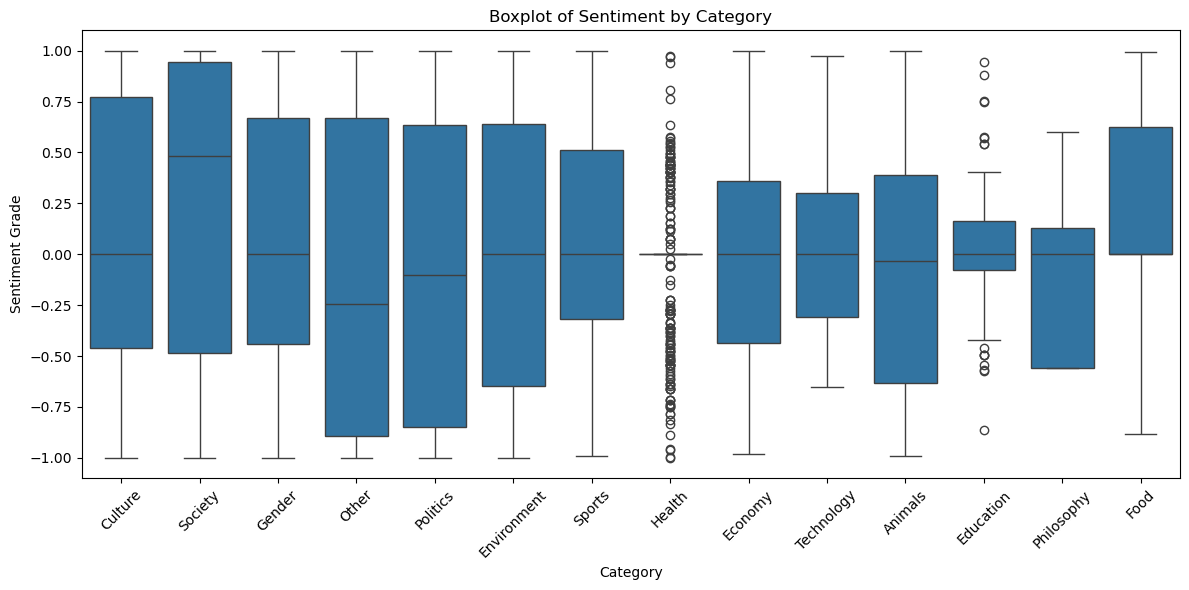

In [28]:
df_plot = n4_categorized.select("category_title", "sentiment")
df_plot_pd = df_plot.toPandas()

plt.figure(figsize=(12, 6))
sns.boxplot(x="category_title", y="sentiment", data=df_plot_pd)
plt.xticks(rotation=45)
plt.title("Boxplot of Sentiment by Category")
plt.xlabel("Category")
plt.ylabel("Sentiment Grade")
plt.tight_layout()
plt.show()

### 3.2 - Posts frequency time series 
Our research differentiates itself by the category labels we added and by looking into time variations to see whether polarization had reached online communities. We explore the link further between time and post sentiment within categories.  

----------------------------------------------------

We notice a significant increment of posts for Politics in October/November 2016.
This was expected since USA's Presidential elections were held on November 8, 2016.

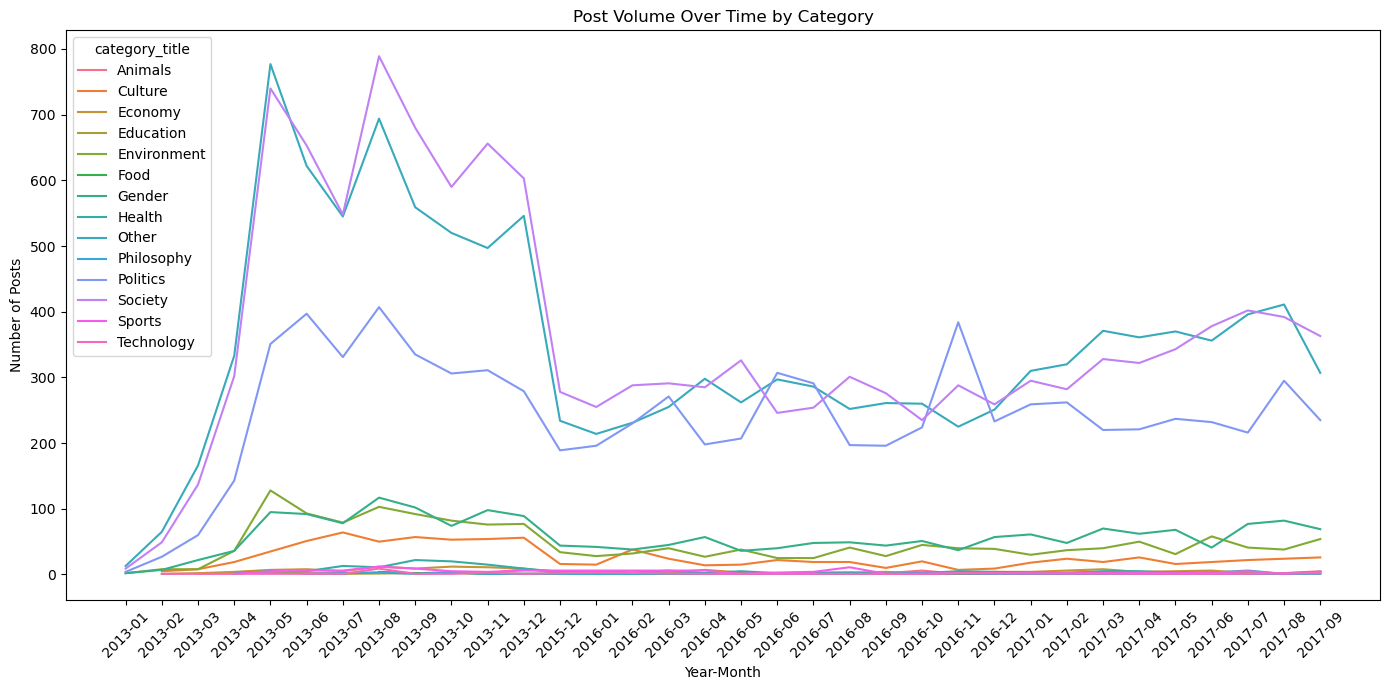

In [14]:
# Frequency of posts throughout time by category
time_category_counts = n4_categorized.groupBy("year_month", "category_title").agg(
    F.count("*").alias("num_posts")
).orderBy("year_month", "category_title")

time_category_pd = time_category_counts.toPandas()


plt.figure(figsize=(14, 7))
sns.lineplot(
    data=time_category_pd,
    x="year_month",
    y="num_posts",
    hue="category_title"
)

plt.xticks(rotation=45)
plt.title("Post Volume Over Time by Category")
plt.xlabel("Year-Month")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()


### 3.3 - Temporal Sentiment analysis across categories

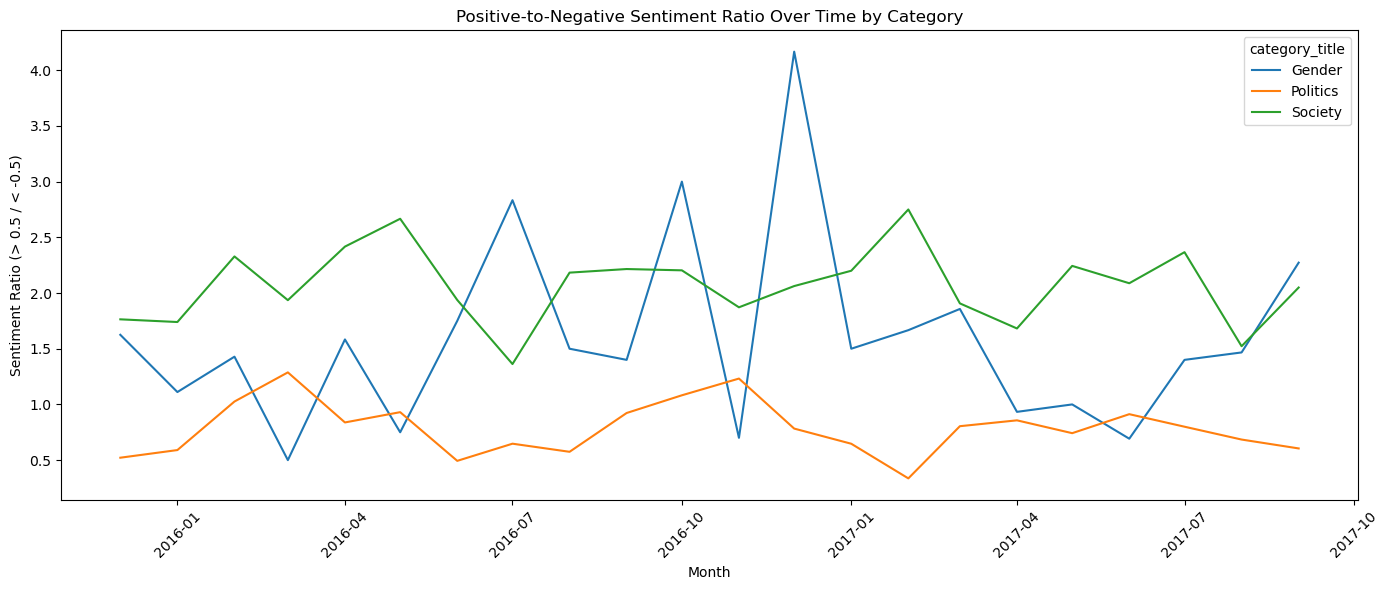

In [21]:
# Posts with strongly positive sentiment
positive = n4_categorized.filter(F.col("sentiment") > 0.5) \
    .groupBy("category_title", "year_month") \
    .agg(F.count("*").alias("num_positive"))

# Posts with strongly negative sentiment
negative = n4_categorized.filter(F.col("sentiment") < -0.5) \
    .groupBy("category_title", "year_month") \
    .agg(F.count("*").alias("num_negative"))
sentiment_ratio = positive.join(
    negative, on=["category_title", "year_month"], how="outer"
).fillna(0)

# Compute the positive-to-negative ratio 
sentiment_ratio = sentiment_ratio.withColumn(
    "sentiment_ratio",
    F.when(F.col("num_negative") == 0, None).otherwise(
        F.col("num_positive") / F.col("num_negative")
    )
)
ratio_pd = sentiment_ratio.toPandas()
ratio_pd["year_month"] = pd.to_datetime(ratio_pd["year_month"])
ratio_pd = ratio_pd[
    (ratio_pd["year_month"] >= "2014-01") &
    (ratio_pd["year_month"] <= "2017-12")
]

# Ratio for some specific categories
selected_categories = ["Politics", "Society","Gender"]

ratio_pd = ratio_pd[ratio_pd["category_title"].isin(selected_categories)]

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=ratio_pd,
    x="year_month",
    y="sentiment_ratio",
    hue="category_title"
)

plt.title("Positive-to-Negative Sentiment Ratio Over Time by Category")
plt.ylabel("Sentiment Ratio (> 0.5 / < -0.5)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.4 Sentiment across years by categories

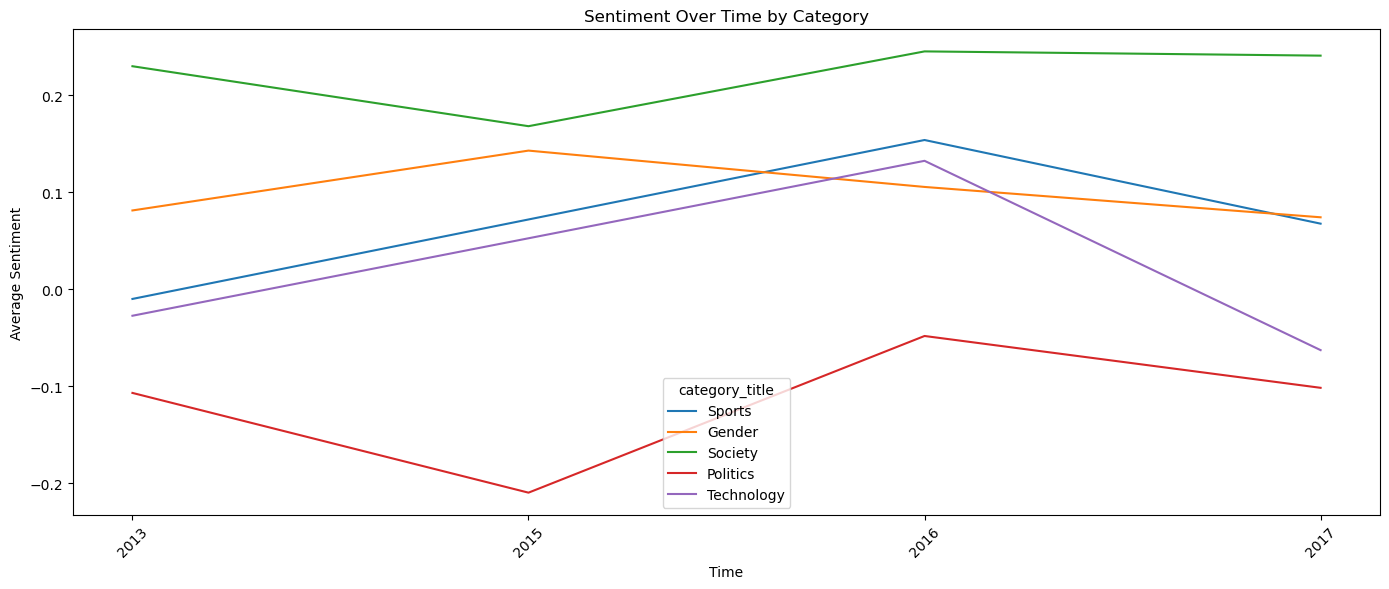

In [26]:
# Select categories to analyze
selected_categories = ["Politics", "Sports", "Society", "Gender", "Technology"]
filtered_df = n4_categorized.filter(col("category_title").isin(selected_categories))


# Extract just the year as a new column
filtered_df = filtered_df.withColumn("year", substring("year_month", 1, 4))

sentiment_trend = (
    filtered_df
    .groupBy("year", "category_title")
    .agg(avg("sentiment").alias("avg_sentiment"))
    .orderBy("year")
)


sentiment_trend_pd = sentiment_trend.toPandas()

plt.figure(figsize=(14, 6))
sns.lineplot(data=sentiment_trend_pd, x="year", y="avg_sentiment", hue="category_title")
plt.title("Sentiment Over Time by Category")
plt.xlabel("Time")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4 - Graphs analysis 

### 4.1 - Deltas against comments 
Until now our research main finding is that deltas are non-linearly driven by the number of comments. Initially, a greater amount of comments increase the likelihood of being convinced, but that reaches a plateau around 25 comments. We explore this here. 

/tmp/ipykernel_16968/73151843.py:15: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


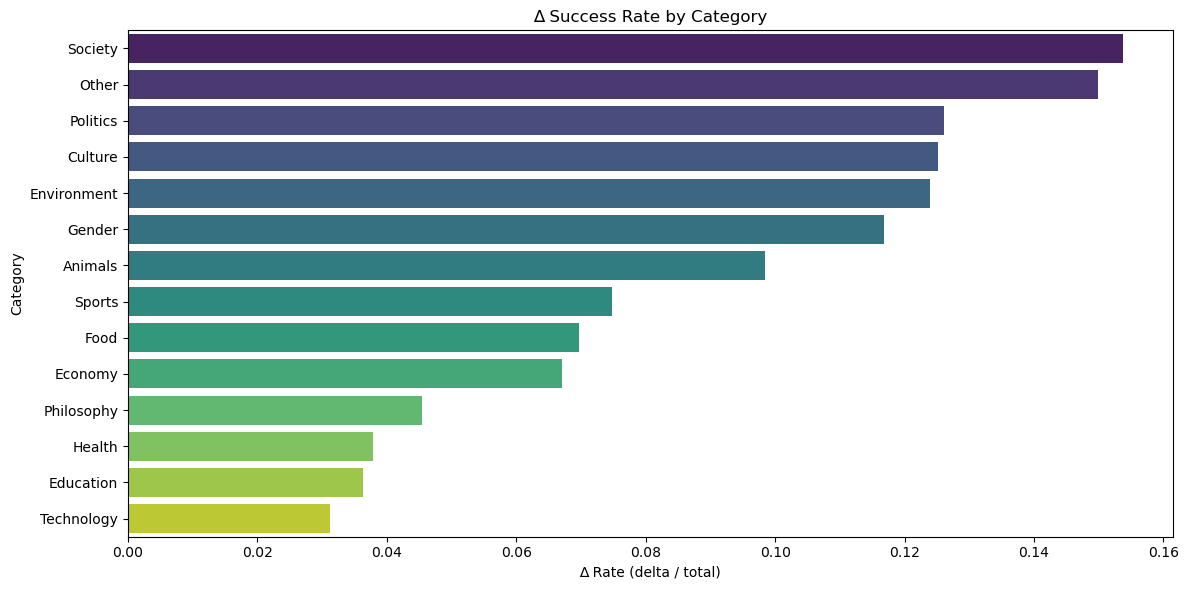

In [7]:
delta_rates = n4_categorized.groupBy("category_title").agg(
    F.sum("delta").alias("delta_sum"),
    F.count("delta").alias("total_posts"),
    (F.sum("delta") / F.count("delta")).alias("delta_rate")
).orderBy("delta_rate", ascending=False)

delta_rates_pd = delta_rates.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    x="delta_rate",
    y="category_title",
    data=delta_rates_pd.sort_values("delta_rate", ascending=False),
    palette="viridis"
)

plt.xlabel("∆ Rate (delta / total)")
plt.ylabel("Category")
plt.title("∆ Success Rate by Category")
plt.tight_layout()
plt.show()

### 4.2 - Delta vs Engagement analysis 
We want to understand how the ratio of deltas varies depending on the average number of comments for each category.

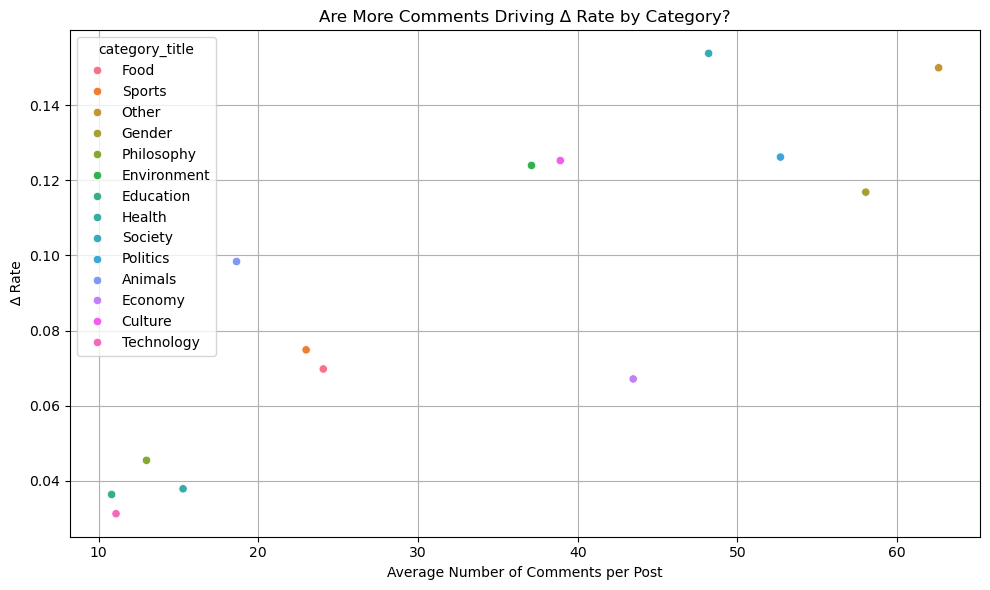

In [10]:
comment_delta_stats = n4_categorized.groupBy("category_title").agg(
    F.avg("num_comments").alias("avg_comments"),
    (F.sum("delta") / F.count("delta")).alias("delta_rate")
)

comment_delta_pd = comment_delta_stats.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=comment_delta_pd,
    x="avg_comments",
    y="delta_rate",
    hue="category_title"
)

plt.xlabel("Average Number of Comments per Post")
plt.ylabel("∆ Rate")
plt.title("Are More Comments Driving ∆ Rate by Category?")
plt.grid(True)
plt.tight_layout()
plt.show()
